# RERUN From detected synch cues, produce restamped raw Equivital and fixed intervals on march 8th, Friday

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

In [2]:
%load_ext autoreload
%autoreload 1
%aimport qex
%aimport al

In [3]:
def remove_tz_from_dataframe(df_in):
    df = df_in.copy()
    col_times = [ col for col in df.columns if any([isinstance(x, pd.Timestamp) for x in df[col]])]
    for col in col_times:
        df[col] = pd.to_datetime(df[col],format='ISO8601') 
        df[col] = df[col].dt.tz_localize(None) 
    return df

In [4]:
cues_df = pd.read_csv('./outfiles/'+'Cue_dev_align_20240308.csv',index_col = 0)
for c in cues_df.columns:
    if c.endswith('dt') or c.endswith('dTime'):
        if c.startswith('dur'):
            cues_df[c] = pd.to_timedelta(cues_df[c])
        else:
            cues_df[c] = pd.to_datetime(cues_df[c])
cues_df

,Cue1_devdTime,Cue1_s,Cue1_r,Cue2_devdTime,Cue2_s,Cue2_r,dur_dt,dur_s,devID,drift_s,drift_rate_sphr,ACCFile,Cue1_file,Cue1_name,Cue1_dt,Cue2_file,Cue2_name,Cue2_dt
DevName,,,,,,,,,,,,,,,,,,
AU808,2024-03-08 06:49:58.098053075,-2.472656,0.607847,2024-03-08 14:04:37.947703075,-0.691406,0.588710,0 days 07:14:39.849650,26079.849650,5022031,-1.781241,-0.245861,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982
AU807,2024-03-08 06:49:56.320709325,-0.695312,0.517968,2024-03-08 14:04:35.893015575,1.363281,0.661651,0 days 07:14:39.572306250,26079.572306,5022058,-2.058585,-0.284143,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982
AU806,2024-03-08 06:49:58.402740575,-2.777344,0.583299,2024-03-08 14:04:38.213328075,-0.957031,0.573120,0 days 07:14:39.810587500,26079.810588,5022155,-1.820304,-0.251253,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982
AU805,2024-03-08 06:49:57.039459325,-1.414062,0.626559,2024-03-08 14:04:36.795359325,0.460938,0.651299,0 days 07:14:39.755900,26079.755900,5022002,-1.874991,-0.258802,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982
AU804,2024-03-08 06:49:56.953521825,-1.328125,0.608979,2024-03-08 14:04:36.549265575,0.707031,0.733450,0 days 07:14:39.595743750,26079.595744,5022184,-2.035147,-0.280908,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982
AU801,2024-03-08 06:49:56.476959325,-0.851562,0.629710,2024-03-08 14:04:36.322703075,0.933594,0.640246,0 days 07:14:39.845743750,26079.845744,5022179,-1.785147,-0.246401,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982
AU809,2024-03-08 06:49:56.742584325,-1.117188,0.548963,2024-03-08 14:04:36.330515575,0.925781,0.578137,0 days 07:14:39.587931250,26079.587931,5022060,-2.042960,-0.281986,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982
AU810,2024-03-08 06:49:57.066803075,-1.441406,0.684348,2024-03-08 14:04:36.826609325,0.429688,0.571643,0 days 07:14:39.759806250,26079.759806,5022098,-1.871085,-0.258262,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982
AU811,2024-03-08 06:49:57.855865575,-2.230469,0.641368,2024-03-08 14:04:37.533640575,-0.277344,0.607188,0 days 07:14:39.677775,26079.677775,5022173,-1.953116,-0.269585,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982


In [5]:
# timing of events for 2024-03-08
df_timings = pd.DataFrame(columns=['Event','Event_Type','SS_sTime','SS_dTime'])
Event_data = {'Event':'','Event_Type':'','SS_sTime':0,'SS_dTime':pd.to_timedelta('nan')}
sync_start = (pd.to_datetime('2024-03-08 06:49:52.625396825')-pd.to_timedelta(22.619,unit='s')).tz_localize(None)

In [6]:
# 19059.7765
i=0
event_dets = Event_data.copy()
event_dets['Event']='Sync'
event_dets['Event_Type']='Sync_Start'
event_dets['SS_sTime']= 22.619
event_dets['SS_dTime']= pd.to_datetime('2024-03-08 06:49:52.625396825').tz_localize(None)
df_timings.loc[i,:]=event_dets

i=1
event_dets = Event_data.copy()
event_dets['Event']='Sync'
event_dets['Event_Type']='Sync_End'
event_dets['SS_sTime']= 26104.256288 # 26081.6309
event_dets['SS_dTime']= pd.to_datetime('2024-03-08 14:04:34.256287982').tz_localize(None) 
df_timings.loc[i,:]=event_dets

i=2
event_dets = Event_data.copy()
event_dets['Event']='C5'
event_dets['Event_Type']='Concert_Start'
event_dets['SS_sTime']= 6223.778
event_dets['SS_dTime']= sync_start + pd.to_timedelta(event_dets['SS_sTime'],unit='s')
df_timings.loc[i,:]=event_dets
# C5 tuning 6223.778
# C6 tuning 284.247 + 12170.971
i=3
event_dets = Event_data.copy()
event_dets['Event']='C5'
event_dets['Event_Type']='Concert_End'
event_dets['SS_sTime']= 9320.296
event_dets['SS_dTime']= sync_start + pd.to_timedelta(event_dets['SS_sTime'],unit='s')
df_timings.loc[i,:]=event_dets

i=4
event_dets = Event_data.copy()
event_dets['Event']='C6'
event_dets['Event_Type']='Concert_Start'
event_dets['SS_sTime']= 284.247 + 12170.971
event_dets['SS_dTime']= sync_start + pd.to_timedelta(event_dets['SS_sTime'],unit='s')
df_timings.loc[i,:]=event_dets

i=5
event_dets = Event_data.copy()
event_dets['Event']='C6'
event_dets['Event_Type']='Concert_End'
event_dets['SS_sTime']= 12170.971 + 3357.236
event_dets['SS_dTime']= sync_start + pd.to_timedelta(event_dets['SS_sTime'],unit='s')
df_timings.loc[i,:]=event_dets

df_timings

,Event,Event_Type,SS_sTime,SS_dTime
0,Sync,Sync_Start,22.619,2024-03-08 06:49:52.625396825
1,Sync,Sync_End,26104.256288,2024-03-08 14:04:34.256287982
2,C5,Concert_Start,6223.778,2024-03-08 08:33:13.784396825
3,C5,Concert_End,9320.296,2024-03-08 09:24:50.302396825
4,C6,Concert_Start,12455.218,2024-03-08 10:17:05.224396825
5,C6,Concert_End,15528.207,2024-03-08 11:08:18.213396825


In [7]:
for ev in ['C5','C6']:
    df_t = df_timings.query('Event == @ev').reset_index(drop = True)
    print(df_t)

  Event     Event_Type  SS_sTime                       SS_dTime
0    C5  Concert_Start  6223.778  2024-03-08 08:33:13.784396825
1    C5    Concert_End  9320.296  2024-03-08 09:24:50.302396825
  Event     Event_Type   SS_sTime                       SS_dTime
0    C6  Concert_Start  12455.218  2024-03-08 10:17:05.224396825
1    C6    Concert_End  15528.207  2024-03-08 11:08:18.213396825


In [8]:
['VN211','VN101']
df_drifts=pd.read_csv('./outfiles/'+'dev_drift.csv', index_col=0)
df_drifts.loc['VN101','median_C']

1.0001486075507473

In [9]:
df_shifts=pd.read_csv('./outfiles/Cue_dev_align_20240308.csv', index_col=0)
df_shifts['Cue1_devdTime'] = pd.to_datetime(df_shifts['Cue1_devdTime']).dt.tz_localize(None)
df_shifts['Cue2_devdTime'] = pd.to_datetime(df_shifts['Cue2_devdTime']).dt.tz_localize(None)
df_shifts['dur_dt'] = pd.to_timedelta(df_shifts['dur_dt'])
df_shifts

,Cue1_devdTime,Cue1_s,Cue1_r,Cue2_devdTime,Cue2_s,Cue2_r,dur_dt,dur_s,devID,drift_s,drift_rate_sphr,ACCFile,Cue1_file,Cue1_name,Cue1_dt,Cue2_file,Cue2_name,Cue2_dt
DevName,,,,,,,,,,,,,,,,,,
AU808,2024-03-08 06:49:58.098053075,-2.472656,0.607847,2024-03-08 14:04:37.947703075,-0.691406,0.588710,0 days 07:14:39.849650,26079.849650,5022031,-1.781241,-0.245861,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982
AU807,2024-03-08 06:49:56.320709325,-0.695312,0.517968,2024-03-08 14:04:35.893015575,1.363281,0.661651,0 days 07:14:39.572306250,26079.572306,5022058,-2.058585,-0.284143,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982
AU806,2024-03-08 06:49:58.402740575,-2.777344,0.583299,2024-03-08 14:04:38.213328075,-0.957031,0.573120,0 days 07:14:39.810587500,26079.810588,5022155,-1.820304,-0.251253,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982
AU805,2024-03-08 06:49:57.039459325,-1.414062,0.626559,2024-03-08 14:04:36.795359325,0.460938,0.651299,0 days 07:14:39.755900,26079.755900,5022002,-1.874991,-0.258802,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982
AU804,2024-03-08 06:49:56.953521825,-1.328125,0.608979,2024-03-08 14:04:36.549265575,0.707031,0.733450,0 days 07:14:39.595743750,26079.595744,5022184,-2.035147,-0.280908,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982
AU801,2024-03-08 06:49:56.476959325,-0.851562,0.629710,2024-03-08 14:04:36.322703075,0.933594,0.640246,0 days 07:14:39.845743750,26079.845744,5022179,-1.785147,-0.246401,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982
AU809,2024-03-08 06:49:56.742584325,-1.117188,0.548963,2024-03-08 14:04:36.330515575,0.925781,0.578137,0 days 07:14:39.587931250,26079.587931,5022060,-2.042960,-0.281986,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982
AU810,2024-03-08 06:49:57.066803075,-1.441406,0.684348,2024-03-08 14:04:36.826609325,0.429688,0.571643,0 days 07:14:39.759806250,26079.759806,5022098,-1.871085,-0.258262,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982
AU811,2024-03-08 06:49:57.855865575,-2.230469,0.641368,2024-03-08 14:04:37.533640575,-0.277344,0.607188,0 days 07:14:39.677775,26079.677775,5022173,-1.953116,-0.269585,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982


In [10]:
data_dir='/Volumes/SeagateHub/BiC2024/20240308/Equivital/Extracted SEM Data/'

sep = '/'
projectName=''
df_datafiles = qex.qiosk_recordings(data_dir,projectName,sep)
df_datafiles.set_index('DevName',inplace=True)
df_datafiles.iloc[:5,:]

,Signal,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,Duration,...,SubjectNames,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION
DevName,,,,,,,,,,,,,,,,,,,,,
AU808,DATA,5022031,240308,0,DATA-AU808-5022031-24030800.CSV,csv,157362,2024-03-08 06:29:53+00:00,2024-03-08 14:25:23+00:00,28530.0,...,[AU808],5022031,AU808,53,0,100,1,1,Stationary,Side
AU807,DATA,5022058,240308,0,DATA-AU807-5022058-24030800.CSV,csv,157379,2024-03-08 06:29:54+00:00,2024-03-08 14:25:54+00:00,28560.0,...,[AU807],5022058,AU807,53,0,100,1,1,Stationary,Side
AU806,DATA,5022155,240308,0,DATA-AU806-5022155-24030800.CSV,csv,157385,2024-03-08 06:29:57+00:00,2024-03-08 14:25:42+00:00,28545.0,...,[AU806],5022155,AU806,53,0,100,1,1,Stationary,Side
AU805,DATA,5022002,240308,0,DATA-AU805-5022002-24030800.CSV,csv,157454,2024-03-08 06:29:58+00:00,2024-03-08 14:25:13+00:00,28515.0,...,[AU805],5022002,AU805,53,0,100,1,1,Stationary,Side
AU804,DATA,5022184,240308,0,DATA-AU804-5022184-24030800.CSV,csv,157573,2024-03-08 06:30:00+00:00,2024-03-08 14:26:00+00:00,28560.0,...,[AU804],5022184,AU804,53,2,100,1,1,Stationary,Side


# Test Realign and cut

In [12]:
#pid = 'VN105'
pid = 'AU805'
dets = df_datafiles.loc[pid,:]
dets

Signal                                                            DATA
ID                                                             5022002
Date                                                            240308
Session                                                              0
FileName                               DATA-AU805-5022002-24030800.CSV
FileType                                                           csv
FileSize                                                        157454
RecStart                                     2024-03-08 06:29:58+00:00
RecEnd                                       2024-03-08 14:25:13+00:00
Duration                                                       28515.0
BatteryStart                                                      4100
BatteryEnd                                                        3930
BatteryChange(mV)                                                 -170
FullLoc              /Volumes/SeagateHub/BiC2024/20240308/Equivital...
DATAlo

In [32]:
df_shifts.loc[pid,:]

Cue1_devdTime                          2024-03-08 06:49:57.039459325
Cue1_s                                                     -1.414062
Cue1_r                                                      0.626559
Cue2_devdTime                          2024-03-08 14:04:36.795359325
Cue2_s                                                      0.460938
Cue2_r                                                      0.651299
dur_dt                                        0 days 07:14:39.755900
dur_s                                                     26079.7559
devID                                                        5022002
drift_s                                                    -1.874991
drift_rate_sphr                                            -0.258802
ACCFile            /Volumes/Seagatehub/BiC2024/20240308/Equivital...
Cue1_file                               ./outfiles/cue1_20240308.csv
Cue1_name                                              cue1_20240308
Cue1_dt                           

In [33]:
df_timings

,Event,Event_Type,SS_sTime,SS_dTime
0,Sync,Sync_Start,22.619,2024-03-08 06:49:52.625396825
1,Sync,Sync_End,26104.256288,2024-03-08 14:04:34.256287982
2,C5,Concert_Start,6223.778,2024-03-08 08:33:36.403396825
3,C5,Concert_End,9320.296,2024-03-08 09:25:12.921396825
4,C6,Concert_Start,12455.218,2024-03-08 10:17:27.843396825
5,C6,Concert_End,15528.207,2024-03-08 11:08:40.832396825


In [34]:
V = pd.read_csv(df_datafiles.loc[pid,'ACCloc'],skipinitialspace=True)
V

,DateTime,Vert Accelerometer,Lat Accelerometer,Long Accelerometer
0,2024-03-08 06:29:30.007+00:00,0,0,0
1,2024-03-08 06:29:30.011+00:00,0,0,0
2,2024-03-08 06:29:30.015+00:00,0,0,0
3,2024-03-08 06:29:30.019+00:00,0,0,0
4,2024-03-08 06:29:30.023+00:00,0,0,0
...,...,...,...,...
7310264,2024-03-08 14:25:25.738+00:00,43,-101,-971
7310265,2024-03-08 14:25:25.742+00:00,35,-105,-975
7310266,2024-03-08 14:25:25.746+00:00,35,-101,-979
7310267,2024-03-08 14:25:25.749+00:00,31,-113,-983


In [35]:
def remove_tz_from_dataframe(df_in):
    df = df_in.copy()
    col_times = [ col for col in df.columns if any([isinstance(x, pd.Timestamp) for x in df[col]])]
    for col in col_times:
        df[col] = pd.to_datetime(df[col],format='ISO8601') 
        df[col] = df[col].dt.tz_localize(None) 
    return df


In [36]:
V = pd.read_csv(df_datafiles.loc[pid,'ACCloc'],skipinitialspace=True)

ACC = pd.DataFrame()
ACC['dev_dTime'] = pd.to_datetime(V['DateTime']).dt.tz_localize(None)
ACC[['X','Y','Z']] = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
ACC['signal'] = np.sqrt(np.square(V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']].diff()).sum(axis=1))

#ACC = remove_tz_from_dataframe(ACC)
ACC.iloc[:5,:]

,dev_dTime,X,Y,Z,signal
0,2024-03-08 06:29:30.007,0,0,0,0.0
1,2024-03-08 06:29:30.011,0,0,0,0.0
2,2024-03-08 06:29:30.015,0,0,0,0.0
3,2024-03-08 06:29:30.019,0,0,0,0.0
4,2024-03-08 06:29:30.023,0,0,0,0.0


In [13]:
sync1_s = 0
sync1_dt = df_timings.loc[0,'SS_dTime']
sync2_s = df_timings.loc[1,'SS_sTime'] - df_timings.loc[0,'SS_sTime']
sync2_dt = df_timings.loc[1,'SS_dTime']

In [14]:
df_shifts.loc[pid,:]

Cue1_devdTime                          2024-03-08 06:49:57.039459325
Cue1_s                                                     -1.414062
Cue1_r                                                      0.626559
Cue2_devdTime                          2024-03-08 14:04:36.795359325
Cue2_s                                                      0.460938
Cue2_r                                                      0.651299
dur_dt                                        0 days 07:14:39.755900
dur_s                                                     26079.7559
devID                                                        5022002
drift_s                                                    -1.874991
drift_rate_sphr                                            -0.258802
ACCFile            /Volumes/Seagatehub/BiC2024/20240308/Equivital...
Cue1_file                               ./outfiles/cue1_20240308.csv
Cue1_name                                              cue1_20240308
Cue1_dt                           

In [15]:
drift_C = (df_timings.loc[1,'SS_sTime'] - df_timings.loc[0,'SS_sTime'])/(df_shifts.loc[pid,'Cue2_devdTime']-df_shifts.loc[pid,'Cue1_devdTime']).total_seconds()
drift_C

1.0000721397856336

In [40]:
drift_C = (df_timings.loc[1,'SS_sTime'] - df_timings.loc[0,'SS_sTime'])/(df_shifts.loc[pid,'Cue2_devdTime']-df_shifts.loc[pid,'Cue1_devdTime']).total_seconds()

ACC['rTime_s'] =np.round((ACC['dev_dTime']-df_shifts.loc[pid,'Cue1_devdTime']).dt.total_seconds()*drift_C,3)+df_timings.loc[0,'SS_sTime']
#  df_timings.loc[0,'SS_sTime'] + 
ACC['rTime_dt'] = pd.to_timedelta(ACC['rTime_s']-df_timings.loc[0,'SS_sTime'],unit='s')+ sync1_dt
ACC.iloc[:5,:]

,dev_dTime,X,Y,Z,signal,rTime_s,rTime_dt
0,2024-03-08 06:29:30.007,0,0,0,0.0,-1204.502,2024-03-08 06:29:25.504396825
1,2024-03-08 06:29:30.011,0,0,0,0.0,-1204.498,2024-03-08 06:29:25.508396825
2,2024-03-08 06:29:30.015,0,0,0,0.0,-1204.494,2024-03-08 06:29:25.512396825
3,2024-03-08 06:29:30.019,0,0,0,0.0,-1204.490,2024-03-08 06:29:25.516396825
4,2024-03-08 06:29:30.023,0,0,0,0.0,-1204.486,2024-03-08 06:29:25.520396825


In [29]:
ACC1 = ACC.copy()

Test out put: are these two signals aligned in rTime_s, in rTime_dt?

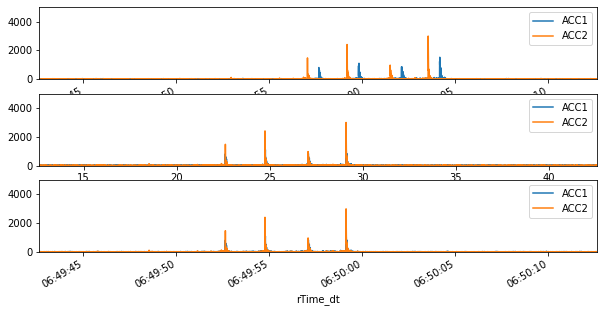

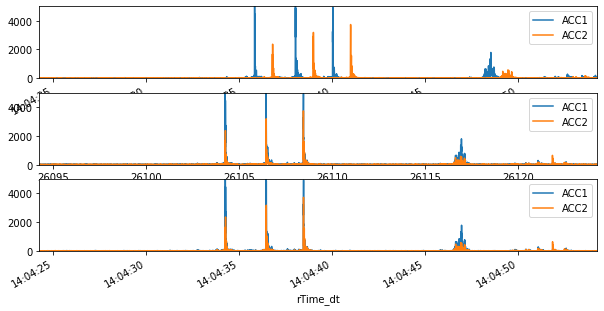

In [43]:
fig, axes = plt.subplots(3,1,figsize=(10,5))
time_cs = ['dev_dTime','rTime_s','rTime_dt']
for i in range(len(time_cs)):
    time_c = time_cs[i]
    ACC1.plot(x=time_c,y='signal',label='ACC1',ax=axes[i])
    ACC.plot(x=time_c,y='signal',label='ACC2',ax=axes[i])
    if time_c.endswith('s'):
        axes[i].set_xlim([df_timings.loc[0,'SS_sTime']-10,df_timings.loc[0,'SS_sTime']+20])
    else:
        axes[i].set_xlim([df_timings.loc[0,'SS_dTime']-pd.to_timedelta(10,unit='s'),df_timings.loc[0,'SS_dTime']+pd.to_timedelta(20,unit='s')])
    axes[i].set_ylim([0,5000])
plt.show()
    
fig, axes = plt.subplots(3,1,figsize=(10,5))
time_cs = ['dev_dTime','rTime_s','rTime_dt']
for i in range(len(time_cs)):
    time_c = time_cs[i]
    ACC1.plot(x=time_c,y='signal',label='ACC1',ax=axes[i])
    ACC.plot(x=time_c,y='signal',label='ACC2',ax=axes[i])
    if time_c.endswith('s'):
        axes[i].set_xlim([df_timings.loc[1,'SS_sTime']-10,df_timings.loc[1,'SS_sTime']+20])
    else:
        axes[i].set_xlim([df_timings.loc[1,'SS_dTime']-pd.to_timedelta(10,unit='s'),df_timings.loc[1,'SS_dTime']+pd.to_timedelta(20,unit='s')])
    axes[i].set_ylim([0,5000])
plt.show()
     

# Output full and for each event


In [81]:
CUTLOGS.index[20:]

Index(['AU802', 'VN101', 'VN104', 'VN105', 'VN109', 'VN110', 'AU803', 'LS404',
       'LS405', 'LS407', 'LS410', 'LS409', 'WW504', 'WW506', 'WW507', 'WW508',
       'BR604', 'BR605', 'BR609', 'BR606', 'BR608', 'PC702', 'PC709', 'PC710'],
      dtype='object', name='DevName')

In [16]:
CUTLOGS = pd.concat([df_datafiles,df_shifts],axis=1)#,CUTLOGS
CUTS= pd.Series()
CUTS[pid] = []

#['DATAloc','ACCloc','RESPloc','RRloc','ECGloc']
# newdata_dir='/Volumes/TaeTae/Stavangar/20240307/'
# data_dir='/Volumes/SeagateHub/BiC2024/Equivital/Extracted SEM Data/'
newdata_dir='/Volumes/SeagateHub/BiC2024_Synced/Equivital/'

sig_map = {'DATAloc':'EQDATA','ACCloc':'EQBACC','RESPloc':'EQRESP','RRloc':'EQCIBI','ECGloc':'EQ2ECG'}
cut_ind = 0
toc = time.time()
rec_day = '20240308'
buff = pd.to_timedelta(15,unit='s') # 2 minute buffer on cutes for concert and stuff pd.to_timedelta(RecTimeSig['rec_sTime'] - ap['Cue0_rst'],unit='s')
segmentid = 'FULL'

for pid in CUTLOGS.index: # had to restart after VN212 as that is missing 
    tic = time.time()
    outfiles = []
    tic = time.time()
    if pid == 'VN101':
        drift_C = df_drifts.loc['VN101','median_C']
    else: 
        drift_C = (df_timings.loc[1,'SS_sTime'] - df_timings.loc[0,'SS_sTime'])/(df_shifts.loc[pid,'Cue2_devdTime']-df_shifts.loc[pid,'Cue1_devdTime']).total_seconds()
    eqfiles = df_datafiles.loc[pid,['DATAloc','ACCloc','RESPloc','RRloc','ECGloc']]
    for f in eqfiles.index:
        SignalID = sig_map[f]
        V = pd.read_csv(eqfiles[f],skipinitialspace=True)
        dt_col = V.columns[0] # assume first column is time, specifically datetime
        sig_col = V.columns[1:]
        V[dt_col]=pd.to_datetime(V[dt_col]).dt.tz_localize(None) # .dt.tz_localize('Europe/Oslo').dt.tz_convert('UTC')

        V['rTime_s'] =np.round((V[dt_col]-df_shifts.loc[pid,'Cue1_devdTime']).dt.total_seconds()*drift_C,4)+df_timings.loc[0,'SS_sTime']
        V['rTime_dt'] = pd.to_timedelta(V['rTime_s']-df_timings.loc[0,'SS_sTime'],unit='s')+ sync1_dt
        RecTimeSig = pd.DataFrame()
        RecTimeSig['rec_sTime'] = np.round((V[dt_col]-df_shifts.loc[pid,'Cue1_devdTime']).dt.total_seconds()*drift_C,4)+df_timings.loc[0,'SS_sTime']
        RecTimeSig['rec_dTime'] = pd.to_timedelta(RecTimeSig['rec_sTime']-df_timings.loc[0,'SS_sTime'],unit='s')+ sync1_dt
        RecTimeSig['dev_dTime'] = V[dt_col]
        RecTimeSig.loc[:,sig_col] = V[sig_col]
        
        seg_filename = '_'.join([pid,rec_day,'FULL',SignalID+'.csv'])
        new_col_order=['rec_sTime']+list(sig_col) + ['rec_dTime','dev_dTime']
        RecTimeSig[new_col_order].to_csv(newdata_dir + 'FullDay/'+ rec_day+ '/'+ seg_filename, index = False)

        new_col_order=['c_sTime']+list(sig_col) + ['rec_dTime','dev_dTime']
        # run through events in that section
        if pid.startswith('AU'):
            evnts = ['C5']
        else: 
            evnts = ['C5','C6']
        for ev in evnts:
            df_t = df_timings.query('Event == @ev').reset_index(drop = True)
            subsig  = al.dt_cut(RecTimeSig,'rec_dTime',df_t.loc[0,'SS_dTime']-buff,df_t.loc[1,'SS_dTime']+buff)
            if subsig is not None:
                subsig['c_sTime'] = np.round((subsig['rec_dTime']-df_t.loc[0,'SS_dTime']).dt.total_seconds(),4)
                #C1_FULL_BR601_EQBACC 
                seg_filename = '_'.join([ev,segmentid,pid,SignalID+'.csv'])
                outfiles.append(seg_filename)
                subsig[new_col_order].to_csv(newdata_dir + ev+'/' + seg_filename, index = False)

        print(' '.join([pid,SignalID ,str(np.round(time.time() - tic,3)),str(np.round(time.time() - toc,3))]))


# CUTS= pd.Series()
# CUTS[pid] = []
CUTLOGS['Output_files']=CUTS
CUTLOGS.to_csv('./outfiles/'+rec_day+'EQIVITALS_CUTLOGS.csv')
# CUTLOGS['Scaling_C'].hist()
# plt.show()
CUTLOGS

AU808 EQDATA 0.124 0.125
AU808 EQBACC 75.291 75.292
AU808 EQRESP 82.649 82.65
AU808 EQCIBI 82.865 82.866
AU808 EQ2ECG 165.5 165.501
AU807 EQDATA 0.174 165.676
AU807 EQBACC 75.256 240.758
AU807 EQRESP 82.464 247.965
AU807 EQCIBI 82.625 248.126
AU807 EQ2ECG 164.091 329.592
AU806 EQDATA 0.141 329.734
AU806 EQBACC 77.864 407.457
AU806 EQRESP 85.186 414.778
AU806 EQCIBI 85.386 414.978
AU806 EQ2ECG 168.405 497.997
AU805 EQDATA 0.154 498.151
AU805 EQBACC 76.401 574.399
AU805 EQRESP 83.627 581.625
AU805 EQCIBI 83.861 581.858
AU805 EQ2ECG 165.74 663.737
AU804 EQDATA 0.178 663.915
AU804 EQBACC 76.073 739.81
AU804 EQRESP 83.208 746.945
AU804 EQCIBI 83.44 747.177
AU804 EQ2ECG 165.317 829.055
AU801 EQDATA 0.14 829.195
AU801 EQBACC 75.319 904.374
AU801 EQRESP 82.387 911.442
AU801 EQCIBI 82.566 911.621
AU801 EQ2ECG 164.112 993.167
AU809 EQDATA 0.152 993.319
AU809 EQBACC 77.567 1070.734
AU809 EQRESP 84.728 1077.896
AU809 EQCIBI 84.892 1078.06
AU809 EQ2ECG 166.196 1159.363
AU810 EQDATA 0.167 1159.53
AU

,Signal,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,Duration,...,drift_s,drift_rate_sphr,ACCFile,Cue1_file,Cue1_name,Cue1_dt,Cue2_file,Cue2_name,Cue2_dt,Output_files
DevName,,,,,,,,,,,,,,,,,,,,,
AU808,DATA,5022031,240308,0,DATA-AU808-5022031-24030800.CSV,csv,157362,2024-03-08 06:29:53+00:00,2024-03-08 14:25:23+00:00,28530.0,...,-1.781241,-0.245861,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982,NaN
AU807,DATA,5022058,240308,0,DATA-AU807-5022058-24030800.CSV,csv,157379,2024-03-08 06:29:54+00:00,2024-03-08 14:25:54+00:00,28560.0,...,-2.058585,-0.284143,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982,NaN
AU806,DATA,5022155,240308,0,DATA-AU806-5022155-24030800.CSV,csv,157385,2024-03-08 06:29:57+00:00,2024-03-08 14:25:42+00:00,28545.0,...,-1.820304,-0.251253,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982,NaN
AU805,DATA,5022002,240308,0,DATA-AU805-5022002-24030800.CSV,csv,157454,2024-03-08 06:29:58+00:00,2024-03-08 14:25:13+00:00,28515.0,...,-1.874991,-0.258802,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982,[]
AU804,DATA,5022184,240308,0,DATA-AU804-5022184-24030800.CSV,csv,157573,2024-03-08 06:30:00+00:00,2024-03-08 14:26:00+00:00,28560.0,...,-2.035147,-0.280908,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982,NaN
AU801,DATA,5022179,240308,0,DATA-AU801-5022179-24030800.CSV,csv,157421,2024-03-08 06:30:02+00:00,2024-03-08 14:25:47+00:00,28545.0,...,-1.785147,-0.246401,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982,NaN
AU809,DATA,5022060,240308,0,DATA-AU809-5022060-24030800.CSV,csv,156960,2024-03-08 06:30:39+00:00,2024-03-08 14:25:54+00:00,28515.0,...,-2.042960,-0.281986,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982,NaN
AU810,DATA,5022098,240308,0,DATA-AU810-5022098-24030800.CSV,csv,156673,2024-03-08 06:30:41+00:00,2024-03-08 14:24:56+00:00,28455.0,...,-1.871085,-0.258262,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982,NaN
AU811,DATA,5022173,240308,0,DATA-AU811-5022173-24030800.CSV,csv,156805,2024-03-08 06:30:42+00:00,2024-03-08 14:25:12+00:00,28470.0,...,-1.953116,-0.269585,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982,NaN


In [17]:
outfiles

['C5_FULL_PC710_EQDATA.csv',
 'C6_FULL_PC710_EQDATA.csv',
 'C5_FULL_PC710_EQBACC.csv',
 'C6_FULL_PC710_EQBACC.csv',
 'C5_FULL_PC710_EQRESP.csv',
 'C6_FULL_PC710_EQRESP.csv',
 'C5_FULL_PC710_EQCIBI.csv',
 'C6_FULL_PC710_EQCIBI.csv',
 'C5_FULL_PC710_EQ2ECG.csv',
 'C6_FULL_PC710_EQ2ECG.csv']

In [64]:
df_datafiles.loc[pid,:]

Signal                                                            DATA
ID                                                             3420426
Date                                                            240308
Session                                                              0
FileName                               DATA-AU802-3420426-24030800.CSV
FileType                                                           csv
FileSize                                                        156433
RecStart                                     2024-03-08 06:34:21+00:00
RecEnd                                       2024-03-08 14:25:51+00:00
Duration                                                       28290.0
BatteryStart                                                      4123
BatteryEnd                                                        3953
BatteryChange(mV)                                                 -170
FullLoc              /Volumes/SeagateHub/BiC2024/20240308/Equivital...
DATAlo

In [47]:
eqfiles

DATAloc    /Volumes/SeagateHub/BiC2024/20240308/Equivital...
ACCloc     /Volumes/SeagateHub/BiC2024/20240308/Equivital...
RESPloc    /Volumes/SeagateHub/BiC2024/20240308/Equivital...
RRloc      /Volumes/SeagateHub/BiC2024/20240308/Equivital...
ECGloc     /Volumes/SeagateHub/BiC2024/20240308/Equivital...
Name: VN211, dtype: object

In [ ]:
# 4099.328 for all segments